In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/NLP100knock/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9147 / 9378
torch.Size([9378, 300])


In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2 bool型 False == 0 True == 1
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
    return hidden

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)



# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


epoch: 1, loss_train: 1.2639, accuracy_train: 0.3981, loss_valid: 1.3041, accuracy_valid: 0.3981, 13.8862sec
epoch: 2, loss_train: 1.0807, accuracy_train: 0.5966, loss_valid: 1.1101, accuracy_valid: 0.5720, 11.9852sec
epoch: 3, loss_train: 1.0687, accuracy_train: 0.5886, loss_valid: 1.1167, accuracy_valid: 0.5622, 11.5552sec
epoch: 4, loss_train: 0.9886, accuracy_train: 0.6430, loss_valid: 1.0360, accuracy_valid: 0.6207, 10.8411sec
epoch: 5, loss_train: 1.1166, accuracy_train: 0.5573, loss_valid: 1.1856, accuracy_valid: 0.5322, 11.4808sec
epoch: 6, loss_train: 1.0198, accuracy_train: 0.6111, loss_valid: 1.0752, accuracy_valid: 0.5862, 11.7831sec
epoch: 7, loss_train: 0.9687, accuracy_train: 0.6352, loss_valid: 1.0566, accuracy_valid: 0.5900, 11.8311sec
epoch: 8, loss_train: 0.9853, accuracy_train: 0.6277, loss_valid: 1.0630, accuracy_valid: 0.5832, 11.1497sec
epoch: 9, loss_train: 1.0019, accuracy_train: 0.6204, loss_valid: 1.0889, accuracy_valid: 0.5780, 11.5875sec
epoch: 10, loss_tra

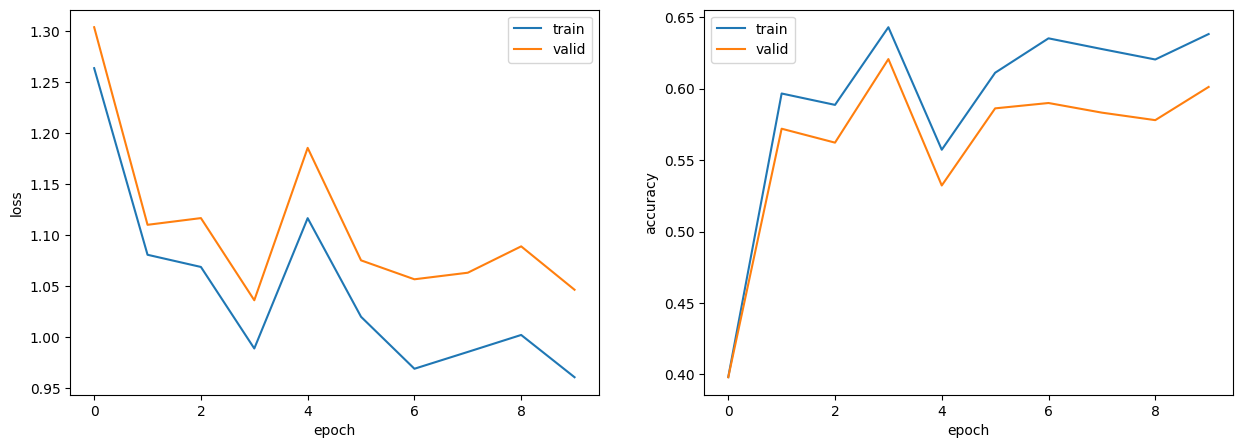

正解率（学習データ）：0.638
正解率（評価データ）：0.619


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')